## NeuroGym Dataset Fix

This notebook demonstrates how to fix the PCG64 BitGenerator error that can occur with NeuroGym datasets.

In [1]:
# Import common packages
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import gym
import neurogym as ngym

/Users/sepehr/Desktop/Ecole Normale/S2/CompNeuroMethods/.venv/lib/python3.9/site-packages/gym/envs/registration.py:396: UserWarning: WARN: The `registry.all` method is deprecated. Please use `registry.values` instead.
  logger.warn(


In [2]:
# First, let's check the NumPy version
print(f"NumPy version: {np.__version__}")

# Set a simple random seed with the legacy numpy random generator
np.random.seed(42)

NumPy version: 2.0.2


In [3]:
# Create the environment (using the same task from the tutorial)
task_name = 'PerceptualDecisionMaking-v0'
kwargs = {'dt': 20, 'timing': {'stimulus': 1000}}

# Create the environment with explicit random seed
env = gym.make(task_name, **kwargs)
# If the environment has a set_rng method, use it
if hasattr(env, 'set_rng'):
    env.set_rng(np.random.RandomState(42))

/Users/sepehr/Desktop/Ecole Normale/S2/CompNeuroMethods/.venv/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:69: UserWarning: WARN: Agent's minimum action space value is -infinity. This is probably too low.
  logger.warn(
/Users/sepehr/Desktop/Ecole Normale/S2/CompNeuroMethods/.venv/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:73: UserWarning: WARN: Agent's maximum action space value is infinity. This is probably too high
  logger.warn(
/Users/sepehr/Desktop/Ecole Normale/S2/CompNeuroMethods/.venv/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:97: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(


Input size 3
Output size 3


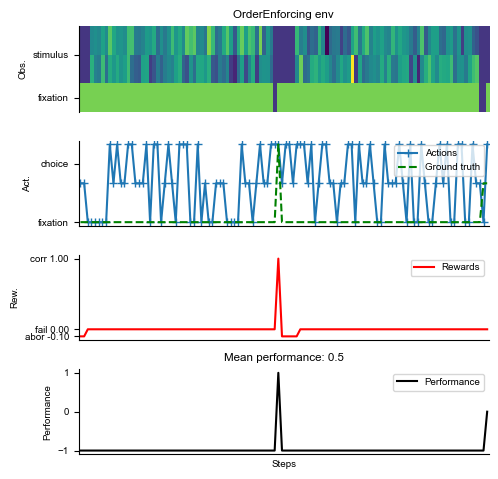

In [11]:
# Visualize the environment with 2 sample trials
_ = ngym.utils.plot_env(env, num_trials=2)

# Check the input and output dimensions
input_size = env.observation_space.shape[0]
output_size = env.action_space.n
print('Input size', input_size)
print('Output size', output_size)

In [7]:
# Create the dataset with explicit random seed
seq_len = 100
batch_size = 16

# Method 1: Try passing a legacy RandomState 
# (sometimes better compatibility with older libraries)
random_state = np.random.RandomState(42)
try:
    dataset = ngym.Dataset(env, batch_size=batch_size, seq_len=seq_len
                        #    , 
                        #   rng=random_state
                          )
    
    # Generate one batch of data
    inputs, target = dataset()
    print('Method 1 Success!')
    print('Input has shape (SeqLen, Batch, Dim) =', inputs.shape)
    print('Target has shape (SeqLen, Batch) =', target.shape)
    print('Target values in the first sequence:')
    print(target[:, 0])
except Exception as e:
    print(f"Method 1 Error: {e}")

Method 1 Error: <numpy.random._pcg64.PCG64 object at 0x1266f00f0> is not a known BitGenerator module.


In [8]:
# Method 2: Try using a different random seed generator
try:
    # Try a different seeding approach
    np.random.seed(42)
    dataset = ngym.Dataset(env, batch_size=batch_size, seq_len=seq_len)
    
    # Patch the _gen_batch method of the dataset if needed
    if hasattr(dataset, '_gen_batch'):
        original_gen_batch = dataset._gen_batch
        def safe_gen_batch(*args, **kwargs):
            np.random.seed(42)  # Reset seed before each batch
            return original_gen_batch(*args, **kwargs)
        dataset._gen_batch = safe_gen_batch
    
    # Generate one batch of data
    inputs, target = dataset()
    print('Method 2 Success!')
    print('Input has shape (SeqLen, Batch, Dim) =', inputs.shape)
    print('Target has shape (SeqLen, Batch) =', target.shape)
    print('Target values in the first sequence:')
    print(target[:, 0])
except Exception as e:
    print(f"Method 2 Error: {e}")

Method 2 Error: <numpy.random._pcg64.PCG64 object at 0x1266f0e00> is not a known BitGenerator module.


In [9]:
# Method 3: Create a custom dataset generator directly from the environment
# This bypasses potential issues with the NeuroGym Dataset class

def custom_dataset_generator(env, batch_size=16, seq_len=100, seed=42):
    """Generate batches of trials directly from the environment"""
    np.random.seed(seed)
    
    # Reset environment
    env.reset(no_step=True)
    
    def generate_batch():
        # Initialize arrays for inputs and targets
        inputs_batch = []
        targets_batch = []
        
        # Generate batch_size trials
        for _ in range(batch_size):
            ob_list = []
            gt_list = []
            
            # Start a new trial
            env.new_trial()
            
            # Collect observations and ground truth for seq_len steps
            for _ in range(seq_len):
                ob, _, _, info = env.step(env.action_space.sample())
                ob_list.append(ob)
                gt_list.append(env.gt_now)
                
                # If trial ended, start a new one
                if info.get('new_trial', False):
                    env.new_trial()
            
            # Convert lists to arrays
            ob_array = np.array(ob_list)
            gt_array = np.array(gt_list)
            
            inputs_batch.append(ob_array)
            targets_batch.append(gt_array)
        
        # Stack along batch dimension and transpose to (seq_len, batch, dim)
        inputs = np.stack(inputs_batch, axis=1)
        targets = np.stack(targets_batch, axis=1)
        
        return inputs, targets
    
    return generate_batch

# Create our custom dataset generator
custom_dataset = custom_dataset_generator(env, batch_size=batch_size, seq_len=seq_len)

# Generate one batch of data
try:
    inputs, target = custom_dataset()
    print('Method 3 Success!')
    print('Input has shape (SeqLen, Batch, Dim) =', inputs.shape)
    print('Target has shape (SeqLen, Batch) =', target.shape)
    print('Target values in the first sequence:')
    print(target[:, 0])
except Exception as e:
    print(f"Method 3 Error: {e}")

Method 3 Success!
Input has shape (SeqLen, Batch, Dim) = (100, 16, 3)
Target has shape (SeqLen, Batch) = (100, 16)
Target values in the first sequence:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


## Using the Working Method for Training

Once we've identified the working dataset generation method above, we can use it for training our RNN models.